# Sentiment Analysis of Ryanair Customer Reviews

Ryanair, a popular low-cost airline that operates in various regions including Europe and North Africa, has recently extended its services to Morocco. This project aims to conduct sentiment analysis on customer reviews of Ryanair to gain a comprehensive understanding of the general sentiment towards the airline and identify potential areas for improvement.

We will start by cleaning the text data and generating sentiment scores using the VADER (Valence Aware Dictionary and sEntiment Reasoner) tool. Then, we will visualize the results to gain a better understanding of the sentiment distribution and explore the relationship between the length of the reviews and their sentiment scores.

Let's get started!

# 1- Scraping Customer Reviews

The aim of this task is to collect customer reviews from the Ryanair page on [https://www.airlinequality.com] by using Python and BeautifulSoup. The collected data will be used for sentiment analysis, which will provide insights into customer feedback about Ryanair. Analyzing customer feedback can help identify any potential issues or trends that need to be addressed by the airline to improve customer satisfaction.

In [30]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

In [31]:
base_url = "https://www.airlinequality.com/airline-reviews/ryanair/"
pages = 20
page_size = 100

Name = []
reviews = []
SeatType = []
Recommend = []
Date=[]
Destination = []

# Loop through each page of reviews
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    # Extract names
    for para in parsed_content.find_all("span", {"itemprop": "name"}):
        Name.append(para.get_text())

    # Extract reviews
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    # Extract seat types
    for para in parsed_content.find_all("tr"):
        if para.find("td", {"class": "review-rating-header cabin_flown"}, text="Seat Type"):
            SeatType.append(para.get_text().replace("Seat Type", ""))

    # Extract recommendation scores
    for para in parsed_content.find_all("table", {"class": "review-ratings"}):
        rec = para.find('td', {'class': ['review-value rating-yes', 'review-value rating-no']})
        if rec is not None:
            Recommend.append(rec.string.strip()[0])
            
    # Extract Date of the review
    for para in parsed_content.find_all("time", {"itemprop": "datePublished"}):
        Date.append(para.get_text())
    

print(f"   ---> {len(Name)} total names")
print(f"   ---> {len(reviews)} total reviews")
print(f"   ---> {len(SeatType)} total Seat Type")
print(f"   ---> {len(Recommend)} total Recommendation")
print(f"   ---> {len(Date)} total Date")

Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10
Scraping page 11
Scraping page 12
Scraping page 13
Scraping page 14
Scraping page 15
Scraping page 16
Scraping page 17
Scraping page 18
Scraping page 19
Scraping page 20
   ---> 2000 total names
   ---> 2000 total reviews
   ---> 2000 total Seat Type
   ---> 2000 total Recommendation
   ---> 2000 total Date


In [32]:
# Create a DataFrame with the collected data
df = pd.DataFrame({
    "name": Name,
    "reviews": reviews,
    "seat_type": SeatType,
    "recommended": Recommend,
    "date_review": Date
})

# Check the shape of the DataFrame
print(f"Shape of the DataFrame: {df.shape}")

Shape of the DataFrame: (2000, 5)


In [33]:
df.head()

,name,reviews,seat_type,recommended,date_review
0,K Vernon,✅ Trip Verified | Frankfurt Hahn to Vilnius re...,Economy Class,y,24th April 2023
1,S Hamoliche,✅ Trip Verified | Very bad experience. The fl...,Economy Class,n,22nd April 2023
2,P Marsele,✅ Trip Verified | Would like to pass a feedba...,Economy Class,y,22nd April 2023
3,U Ali,✅ Trip Verified | I had thought Ryanair would...,Economy Class,n,21st April 2023
4,N Hashan,✅ Trip Verified | Got us late both ways. Also...,Economy Class,n,19th April 2023


In [34]:
df['reviews']

0       ✅ Trip Verified | Frankfurt Hahn to Vilnius re...
1       ✅ Trip Verified |  Very bad experience. The fl...
2       ✅ Trip Verified |  Would like to pass a feedba...
3       ✅ Trip Verified |  I had thought Ryanair would...
4       ✅ Trip Verified |  Got us late both ways. Also...
                              ...                        
1995    First time with Ryanair. Just me and my two yo...
1996    Tenerife to Manchester. Flight left on time an...
1997    London Stansted to Fuerteventura out on 20th N...
1998    The bad press surrounding Ryanair proved to be...
1999    We returned from Gran Canaria to Stansted on t...
Name: reviews, Length: 2000, dtype: object

In [35]:
# Split reviews on | and return the last element.
df["reviews"] = df["reviews"].apply(lambda x: x.split("|", 1)[-1] if "| " in x else x)

In [36]:
# Remove ordinal indicator from date strings
df["date_review"] = df["date_review"].apply(lambda x: re.sub(r'\b(\d+)(st|nd|rd|th)\b', r'\1', x))

# Convert date strings to datetime format
df["date_review"] = pd.to_datetime(df["date_review"], format="%d %B %Y")

In [37]:
df.head()

,name,reviews,seat_type,recommended,date_review
0,K Vernon,Frankfurt Hahn to Vilnius return. Incredible ...,Economy Class,y,2023-04-24
1,S Hamoliche,Very bad experience. The flight was delayed ...,Economy Class,n,2023-04-22
2,P Marsele,Would like to pass a feedback to Antonio and...,Economy Class,y,2023-04-22
3,U Ali,I had thought Ryanair would have improved ov...,Economy Class,n,2023-04-21
4,N Hashan,Got us late both ways. Also caused us to mis...,Economy Class,n,2023-04-19


# 2- Sentiment Analysis of Ryanair Customer Reviews

In the Sentiment Analysis of Ryanair Customer Reviews section, we will perform sentiment analysis on the customer reviews collected in the previous section. Sentiment analysis is a technique used to determine the emotional tone of a piece of text. In this case, we will use sentiment analysis to determine whether the customer reviews of Ryanair are positive or negative. The analysis will involve preprocessing the text data, using a pre-trained sentiment analysis model to assign a sentiment score to each review, and analyzing the results to draw conclusions about customer sentiment towards Ryanair.

## 2-1- Cleaning the text

In [41]:
import re
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [42]:
def clean_review(text):
    # Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    
    # Convert all characters to lowercase
    text = text.lower()
    
    # Tokenize each review
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize each word in each review
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Combine the cleaned tokens back into a string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [43]:
# Cleaning the text in the review column
df['cleaned reviews'] = df['reviews'].apply(clean_review)
df.head()

,name,reviews,seat_type,recommended,date_review,cleaned reviews
0,K Vernon,Frankfurt Hahn to Vilnius return. Incredible ...,Economy Class,y,2023-04-24,frankfurt hahn vilnius return incredible exper...
1,S Hamoliche,Very bad experience. The flight was delayed ...,Economy Class,n,2023-04-22,bad experience flight delayed almost hour pay ...
2,P Marsele,Would like to pass a feedback to Antonio and...,Economy Class,y,2023-04-22,would like pas feedback antonio cabin crew ope...
3,U Ali,I had thought Ryanair would have improved ov...,Economy Class,n,2023-04-21,thought ryanair would improved year completely...
4,N Hashan,Got us late both ways. Also caused us to mis...,Economy Class,n,2023-04-19,got u late way also caused u miss following tr...


In [44]:
df[["reviews", "cleaned reviews"]]

,reviews,cleaned reviews
0,Frankfurt Hahn to Vilnius return. Incredible ...,frankfurt hahn vilnius return incredible exper...
1,Very bad experience. The flight was delayed ...,bad experience flight delayed almost hour pay ...
2,Would like to pass a feedback to Antonio and...,would like pas feedback antonio cabin crew ope...
3,I had thought Ryanair would have improved ov...,thought ryanair would improved year completely...
4,Got us late both ways. Also caused us to mis...,got u late way also caused u miss following tr...
...,...,...
1995,First time with Ryanair. Just me and my two yo...,first time ryanair two young grandchild priori...
1996,Tenerife to Manchester. Flight left on time an...,tenerife manchester flight left time arrived m...
1997,London Stansted to Fuerteventura out on 20th N...,london stansted fuerteventura th november retu...
1998,The bad press surrounding Ryanair proved to be...,bad press surrounding ryanair proved totally u...


In this step, we performed extensive cleaning on the text data in the reviews column by removing special characters and numericals, converting all characters to lowercase, tokenizing each review, removing stopwords, and lemmatizing each word in every review. By doing so, we created a new column called "cleaned reviews" which was a prerequisite for the sentiment analysis.

## 2-2- Generating Sentiment Scores for Cleaned Reviews

Now that we have cleaned and prepared the text data, it's time to delve into sentiment analysis using the powerful Vader SentimentIntensityAnalyzer from the NLTK library. This analyzer allows us to assign a compound score to each review, which quantifies the overall sentiment of the text as positive, negative or neutral. By applying this technique to the cleaned reviews, we can gain insights into how customers are feeling about Ryanair's services, and identify any trends or patterns in their sentiment that can help inform business decisions.

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [46]:
analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment and analysis
def vader_sentiment_analysis(review):
    vs = analyzer.polarity_scores(review)
    compound = vs['compound']
    sentiment = 'Positive' if compound >= 0.5 else 'Negative' if compound < 0 else 'Neutral'
    return compound, sentiment

df[['Compound Score', 'Sentiment']] = df['cleaned reviews'].apply(vader_sentiment_analysis).tolist()

In [47]:
df.head()

,name,reviews,seat_type,recommended,date_review,cleaned reviews,Compound Score,Sentiment
0,K Vernon,Frankfurt Hahn to Vilnius return. Incredible ...,Economy Class,y,2023-04-24,frankfurt hahn vilnius return incredible exper...,0.9295,Positive
1,S Hamoliche,Very bad experience. The flight was delayed ...,Economy Class,n,2023-04-22,bad experience flight delayed almost hour pay ...,-0.7732,Negative
2,P Marsele,Would like to pass a feedback to Antonio and...,Economy Class,y,2023-04-22,would like pas feedback antonio cabin crew ope...,0.9169,Positive
3,U Ali,I had thought Ryanair would have improved ov...,Economy Class,n,2023-04-21,thought ryanair would improved year completely...,-0.6179,Negative
4,N Hashan,Got us late both ways. Also caused us to mis...,Economy Class,n,2023-04-19,got u late way also caused u miss following tr...,-0.6908,Negative


## 2-3- Sentiment Analysis Report

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [49]:
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

Negative    903
Positive    833
Neutral     264
Name: Sentiment, dtype: int64


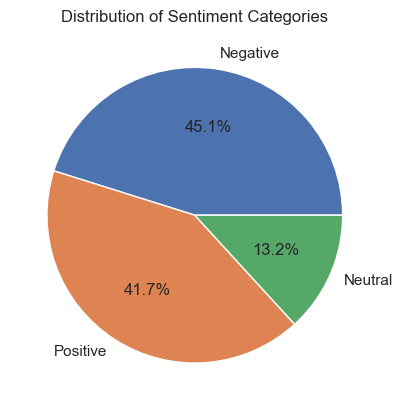

In [50]:
# Get the counts of each sentiment category
counts = df['Sentiment'].value_counts()

# Create a pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribution of Sentiment Categories')
plt.show()

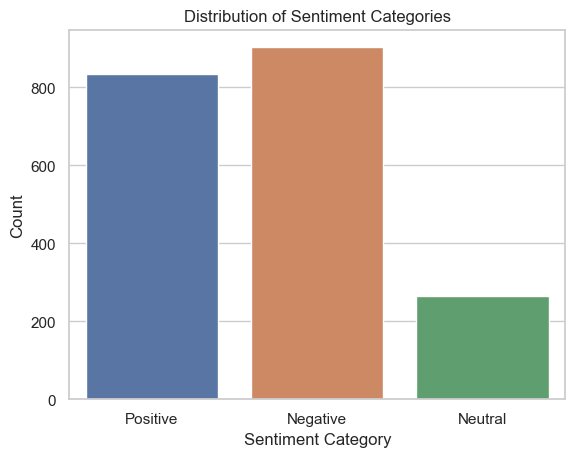

In [51]:
# Visualize the distribution of sentiment categories in the dataset
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

- The number of negative reviews (905) is slightly higher than the number of positive reviews (831).
- The number of neutral reviews (264) is much lower than both negative and positive reviews.
- Based on these numbers, it appears that customers are more likely to have a negative experience with Ryanair than a positive one. However, this is just a preliminary observation and would need to be further analyzed to draw any conclusions.

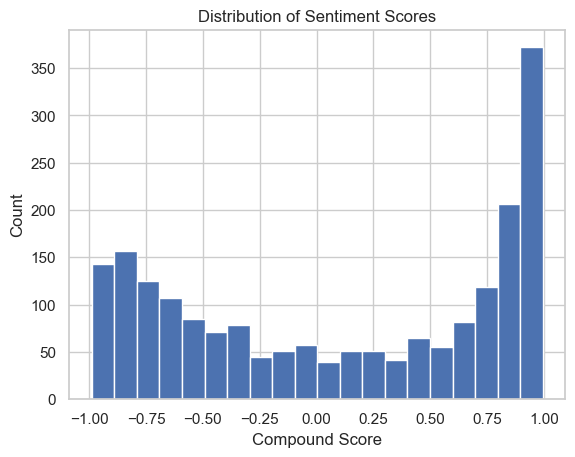

In [52]:
# create a histogram of the Compound Score in the data frame.
plt.hist(df['Compound Score'], bins=20)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Count')
plt.show()

In [53]:
df['Length'] = df['cleaned reviews'].apply(len)

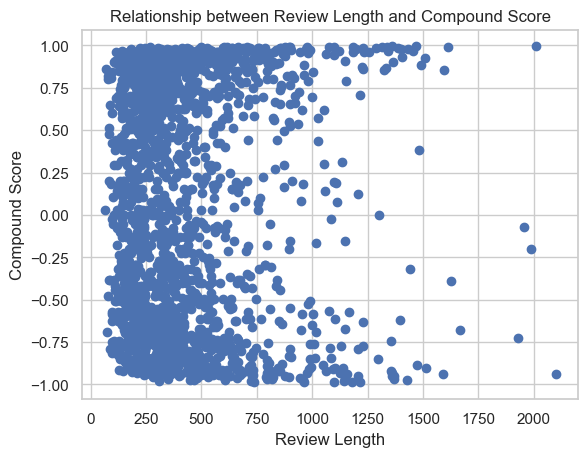

In [54]:
plt.scatter(df['Length'], df['Compound Score'])
plt.title('Relationship between Review Length and Compound Score')
plt.xlabel('Review Length')
plt.ylabel('Compound Score')
plt.show()

- The graph shows that there is no clear correlation between the length of the review and the compound sentiment score. The points are scattered in the graph, which means that reviews can have a similar sentiment score even if they have different lengths. This indicates that the length of the review is not a determining factor for the sentiment score.

In [55]:
seat_type_counts = df["seat_type"].value_counts()
print(seat_type_counts)

Economy Class      1982
Premium Economy      13
Business Class        3
First Class           2
Name: seat_type, dtype: int64


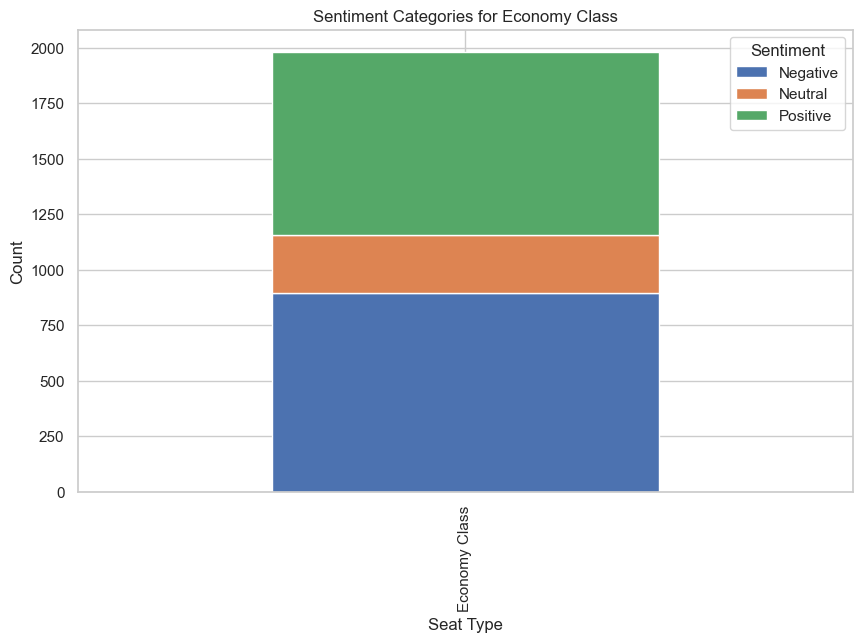

In [56]:
# Filter the DataFrame to include only rows with 'Economy Class' seat type
economy_df = df[df['seat_type'] == 'Economy Class']

# Create a pivot table with sentiment categories by seat type
pivot = pd.pivot_table(economy_df, values='reviews', index='seat_type', columns='Sentiment', aggfunc=len)

# Create a stacked bar plot
sns.set(style='whitegrid')
pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Categories for Economy Class')
plt.xlabel('Seat Type')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper right')
plt.show()

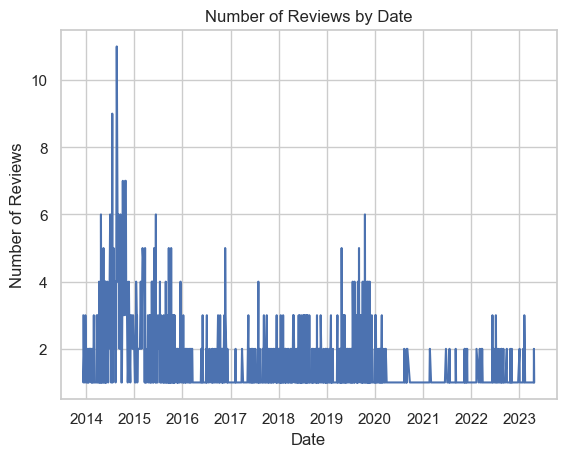

In [57]:
review_counts = df.groupby('date_review').size().reset_index(name='count')
plt.plot(review_counts['date_review'], review_counts['count'])
plt.title('Number of Reviews by Date')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

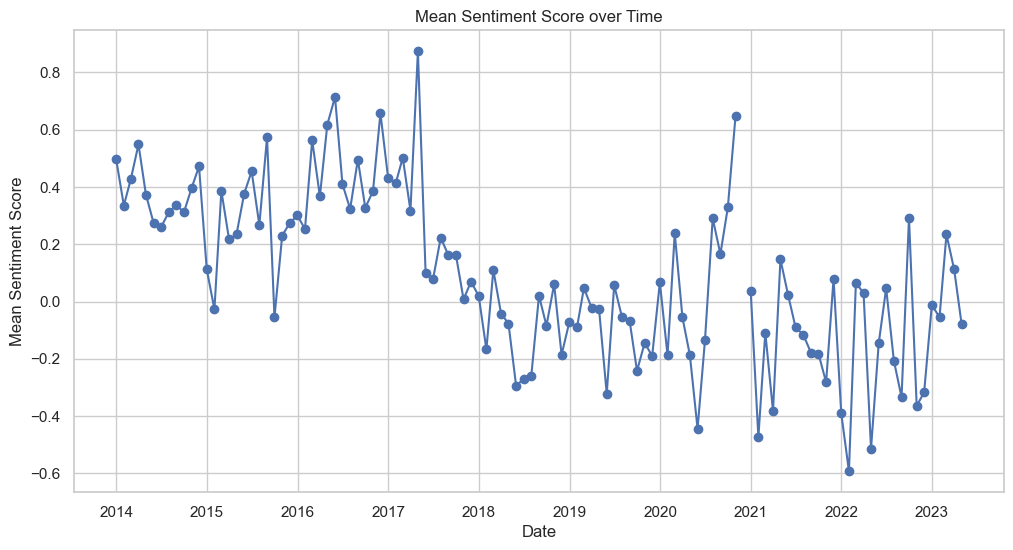

In [58]:
# Group the data by date and calculate the mean sentiment score for each date
df_date = df.groupby('date_review')['Compound Score'].mean().reset_index()

# Set the date column as the index
df_date.set_index('date_review', inplace=True)

# Resample the data by month and calculate the mean sentiment score for each month
df_month = df_date.resample('M').mean()

# Create a line plot of sentiment scores over time
plt.figure(figsize=(12,6))
plt.plot(df_month.index, df_month['Compound Score'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment Score')
plt.title('Mean Sentiment Score over Time')
plt.show()


- The plot shows that the average sentiment score for Ryanair reviews has been declining over time. This suggests that customers are becoming less satisfied with Ryanair's services.

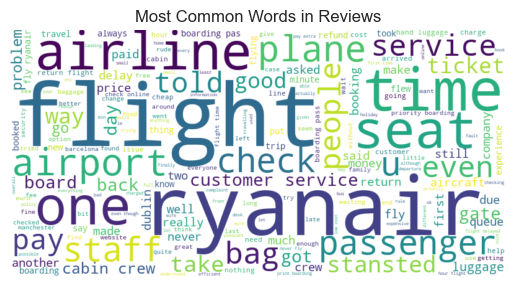

In [59]:
words = ' '.join(df['cleaned reviews'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()

# Conclusion

After conducting our analysis, it can be concluded that the sentiment of airline reviews for Ryanair is predominantly negative. The decrease in customer satisfaction over time highlights the need for Ryanair to address the key issues raised by customers, including delays, cancellations, and poor customer service. Improving these factors could enhance the overall customer experience, resulting in increased customer satisfaction and potential customer attraction. Therefore, it is essential for Ryanair to take measures to improve its customer service and address the specific complaints to ensure a better reputation and maintain customer loyalty.